# Getting the Data

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version = 1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']
X.shape, y.shape #there are 70,000 images and each image has 784 features.
                #this is because each image is 28 x 28 pixels and each feature simply reps one pixel's intensity

((70000, 784), (70000,))

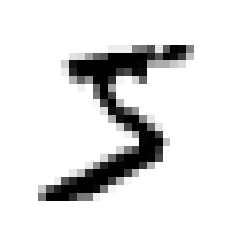

In [3]:
#Let's take a peek at one digit from the dataset:
#All you need to do is grab an instance's feature vector, reshape it to a 28 x 28 array and display it using mpl's imshow()
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation = 'nearest')
plt.axis('off')
plt.show()

In [4]:
#this loooks like a 5, and indeed that's what the label tells us
y[0]

'5'

In [5]:
#Note that the label is a string. We prefer no.s, so let's cast y to integers:
import numpy as np

y = y.astype(np.uint8)

## Creating a Test Set

In [6]:
# The MNIST dataset is actually already split into a training set (the first 60,000 images) and
#a test set (the last 10,000 images):
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000]

In [7]:
#The training set is already shuffled for us, which is good as this guarantees that all cross-validation folds will be 
#similar (you don’t want one fold to be missing some digits).
#Moreover, some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they 
#get many similar instances in a row. Shuffling the dataset ensures that this won’t happen.
# N/B:Shuffling may be a bad idea in some contexts—for example, if you are working on time series data (such as
#stock market prices or weather conditions).

# Training a Binary Classifier

In [8]:
#Let’s simplify the problem for now and only try to identify one digit—for example, the number 5.
#Let's create the target vectors for this classification task:
y_train_5 = (y_train == 5) #True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

In [9]:
#Let's create an SGDClassifier and train it on the whole training set:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [10]:
#N/B: SGDClassifier relies on randomness during training(hence the name 'stochastic').
#if you want reproducible results, you should set the random state parameter

In [11]:
#now you can use it to detect images of the no. 5:
sgd_clf.predict([some_digit])

array([ True])

# Performance Measures

In [12]:
#Evaluating a classifier is often significantly trickier than evaluating a regressor.
#There are many performance measures available:

## 1. Measuring Accuracy Using Cross-Validation

In [13]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [14]:
#above 95% on all cross_validation folds!
#let's look at a very dumb classifier that just classifies every single image in the 'not 5' class
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y = None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)
    
never_5_clf = Never5Classifier()    
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

array([0.91125, 0.90855, 0.90915])

In [15]:
#it has over 90% accuracy!
#This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5,
#you will be right about 90% of the time.
#This demonstrates why accuracy is normally not the preferred performance measure for classifiers

### Implementing Cross_Validation

In [16]:
#Ocassionally you will need more control over the cross validation process than what Scikit-Learn provides off-the-shelf.
#In these cases, you can implement cross_validation yourself.
#The following code does roughly the same thing as Scikit-Learn's cross_val_score() function, and prints the same results:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state = 42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

C:\Users\Okombo\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.95035
0.96035
0.9604


In [17]:
#The StratifiedKFold class performs stratified sampling to produce folds that contain a representative ratio of each class.
#At each iteration the code creates a clone of the classifier, trains that clone on the training folds, and makes 
#predictions on the test fold.
#Then it counts the number of correct predictions and outputs the ratio of correct predictions.

## 2. Confusion Matrix

In [18]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

In [19]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [20]:
#each row in a confusion matrix represents an actual class, while each column reps a predicted class.
#the first row of this matrix considers non-5 images (the -ve class):
#53,892 of them were correctly classified as non-5s(they are called true -ves), while the remaining 687 were wrongly
#classified as 5s(false +ves).
#the second row considers the images of 5s(the + class):
#1,891 were wrongly classified as non-5s(false -ves), while the remaining 3530 were correctly classified as 5s(true +ves).
#A perfect classifier would only have true +ves and true -ves, so its confusion matrix would have non-zero values
#only on its main diagonal

In [21]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfect prediction
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

## 3. Precision and Recall

In [22]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred) # == 3530 / (3530 + 687)

0.8370879772350012

In [23]:
recall_score(y_train_5, y_train_pred) # == 3530 / (3530 + 1891)

0.6511713705958311

In [24]:
# when the classifier claims that an image is a 5, it is correct 83.7% of the time.
#Moreover, it only detects 65.11% of the 5s.

In [25]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

### Precision/Recall Tradeoff

In [26]:
#To understand this tradeoff, let's look at how the SGDClassifier makes its classification decisions.
#For each instance, it computes a score based on a decision function, and if that score is greater than a threshold,
#it assigns the instance to the +ve class, or else it assigns it to the -ve class.
#Raising the threshold decreases recall, conversely, lowering the threshold increases recall and reduces precision.
#Scikit-Learn does not let you set the threshold directly, but it does give you access to the decision scores that it uses 
#to make predictions.

In [27]:
#Instead of calling a classifier's predict() method, you can call its decision_function(), which returns a score for each
#instance, and then make predictions based on those scores using any threshold you want:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [28]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [29]:
#The SGDClassifier uses a threshold = 0, so the previous code return the same result as the predict() method(i.e., True)
#Let's raise the threshold
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [30]:
#This confirms that raising the threshold decreases recall.
#The image actually reps a 5, and the classifier detects it when the threshold is 0, but it misses it when the threshold is
#increased to 8000.

#### How to decide which threshold to use

In [31]:
#you will first need to get the scores of all instances in the training set using the cross_val_predict() function but this
#time specifying that you want it to return decision_scores instead of predictions:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = 'decision_function')

In [32]:
#with these scores, you can compute precision and recall for all possible thresholds using the precision-recall-curve() function
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds, = precision_recall_curve(y_train_5, y_scores)

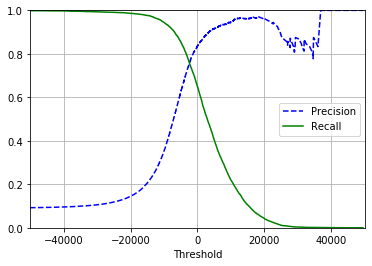

In [33]:
#Finally you can plot precision and recall as functions of the threshold value
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label = 'Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label = 'Recall')
    plt.legend(loc = 'right')
    plt.axis([-50000, 50000, 0.0, 1.0])
    plt.xlabel('Threshold')
    plt.grid()
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)    
plt.show()

In [34]:
# You may wonder why the precision curve is bumpier than the recall curve:
#The reason is that precision may sometimes go down when you raise the threshold (although, in general it will go up).
#On the other hand, recall can only go down when the threshold is increased, which explains why its curve is smooth.

Text(0, 0.5, 'Precision')

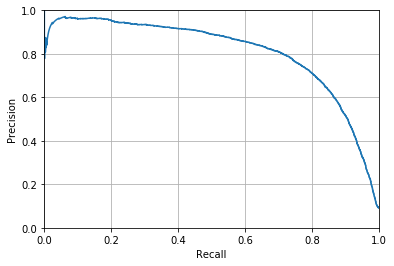

In [35]:
#Another way to select a good precision/recall tradeoff is to plot precision directly against recall
plt.plot(recalls, precisions)
plt.grid()
plt.axis([0, 1, 0, 1])
plt.xlabel('Recall')
plt.ylabel('Precision')

In [36]:
#You can see that the precision really starts to fall sharply at around 70% recall.
#You will probably want to select a precision/recall tradeoff just before that drop. For example, at around 60% recall.
#But of course, the choice depends on your project.
#For example, if you are aiming for 90% precision, you look up the 1st plot and find out that you need to use a threshold of
#about 5000.
#To be more precise you can search for the lowest threshold that gives you about 90% precision:
#np.argmax() will give us the first index of the max value(which in this case means the first True value)
threshold_90_precision =thresholds[np.argmax(precisions >= 0.9)]
threshold_90_precision

3370.0194991439557

In [37]:
#to make predictions(on the training set for now), instead of calling the classifier's predict() method, you can just
#run this code:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [38]:
#Let's check these predictions' precision and recall
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [39]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

## 4. The ROC Curve

In [40]:
# To plot the ROC Curve, you first need to compute the TPR and FPR for various threshold values, using the roc_curve() function:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

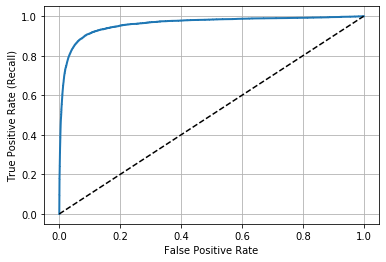

In [41]:
#Now you can plot the FPR against the TPR:
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0, 1], 'k--') #dashed diagonal
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.grid()
    
plot_roc_curve(fpr, tpr)    
plt.show()

In [42]:
#Once again, there is a tradeoff:
#the higher the recall(TPR) the more false positives(FPR) the classifier produces.
#The dotted line reps the ROC curve of a purely random classifier;
#a good classifier stays as far away from that line as possible(toward the top-left corner)

In [43]:
#one way to compare classifiers is to measure the area under the curve(AUC)
#a perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [44]:
#Since the ROC curve is so similar to the precision/recall (or PR) curve, you may wonder how to decide which one to use.
#As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about
#the false positives than the false negatives, and the ROC curve otherwise.

In [45]:
# Let's train a RandomForestClassifier amd compare its ROC curve and ROC AUC score to that of the SGDClassifier.
#First you need to get scores for each instance in the training set;
#But due to the way it works, the RandomForestClassifier does not have a decision_function() method.
#Instead it has a predict_proba() method. Scikit-Learn classifiers generally have one or the other.
#The predict_proba() method returns an array containing a row per instance and a column per class,
#each cotaining the probability that the given instance belongs to the given class
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method = 'predict_proba')

In [46]:
#But to plot a ROC Curve, you need scores not probabilities.
#A simple soln is to use the +ve class's probability as the score
y_scores_forest = y_probas_forest[:, 1] #score = proba of +ve class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

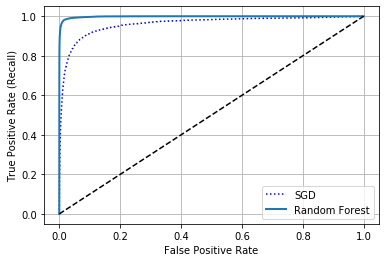

In [47]:
#it is useful to plot the 1st ROC Curve as well to see how they compare
plt.plot(fpr, tpr, 'b:', label = 'SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc = 'lower right')
plt.show()

In [48]:
# The RandomForestClassifer's ROC Curve looks much better that the SGDClassifier's: it comes much closer to the top-left corner.
# As a result its ROC AUC score is significantly much better:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

# Multiclass Classification

In [49]:
#Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task,
#and it automatically runs OvA(except for SVM classifiers for which it uses OvO):
sgd_clf.fit(X_train, y_train) #y_train, not y_train_5
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [50]:
#This code trains the SGDClassifier on the original trainig set using the original target classes from 0 to 9(y_train),
#instead of the 5-versus-all target classes(y_train_5).
#Under the hood, Scikit-learn actually trained 10 binary classifiers, got their decision scores for the image, and 
#selected the class with the highest score.
#To see this is indeed the case, you can call the decision_function() method.
#Instead of returning just one score per instance, it now returns 10 scores, one per class
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [51]:
#the highest score is indeed the one corresponding to class 3
np.argmax(some_digit_scores)

3

In [52]:
#When a classifier is trained, it stores the list of target classes in its classes_ attribute, ordered by value.
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [53]:
#In this case, the index of each class in the classes_ array conveniently matches the class itself
#(e.g., the class at index 5 happens to be class 5), but in general you won’t be so lucky.
sgd_clf.classes_[5]

5

In [54]:
#If you want to force ScikitLearn to use one-versus-one or one-versus-all, you can use
#the OneVsOneClassifier or OneVsRestClassifier classes.
#Simply create an instance and pass a binary classifier to its constructor. For example, this code creates a multiclass
#classifier using the OvO strategy, based on a SGDClassifier:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state = 42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [55]:
len(ovo_clf.estimators_)

45

In [56]:
#Training a RandomForestClassifier is just as easy:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=uint8)

In [57]:
#This time Scikit-Learn did not have to run OvA or OvO because Random Forest classifiers can directly classify instances
#into multiple classes.

In [58]:
#You can call predict_proba() to get the list of probabilities that the classifier assigned to each instance for each class.
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

In [59]:
#Now of course you want to evaluate these classifiers.
#As usual, you want to use crossvalidation. Let’s evaluate the SGDClassifier’s accuracy using the cross_val_score() function:
cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = 'accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [60]:
#It gets over 85% on all test folds.
#If you used a random classifier, you would get 10% accuracy, so this is not such a bad score, but you can still do much better.
#For example, simply scaling the inputs increases accuracy above 89%.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = 'accuracy')

array([0.8983, 0.891 , 0.9018])

# Error Analysis

In [61]:
# After finding a promising model, you may want to find ways to improve it.
#One way to do this is to analyze the types of errors it makes.
#First you can look at the confusion matrix:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

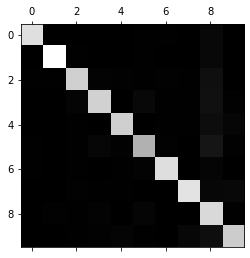

In [62]:
#it is often more convenient to look at an image representation of the confusion matrix using Matplotlib's matshow() function:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

In [63]:
#This confusion matrix look's fairly good, since most images are on the main diagonal, which means that they were classified
#correctly.
#Let's focus the plot on the errors.
#First you need to divide each value in the confusion matrix by the no. of images in the corresponding class so you can compare
#error rates instead of absolute no. of errors(which would make abundant classes look unfairly bad):
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums

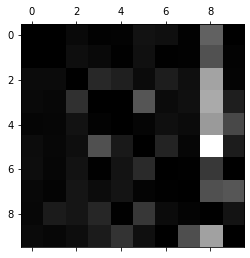

In [64]:
#Now let's fill the diagonal with zeros to keep only the errors, and let's plot the results:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

In [65]:
#The column for class 8 is quite bright which tells you that many images get misclassified as 8s.
#However, the row for class 8 is not that bad, telling you that actual 8s in general get properly classified as 8s.
#You can also see that 3s and 5s also get confused(in both directions).

In [66]:
#Looking at this plot, it seems that your efforts should be spent on reducing the false 8s:
#1. For example, you could try to gather more training data for digits that look like 8s but are not so the classifier can
#learn to distinguish them from real 8s.
#2. Or you could engineer new features that would help the classifier—for example, writing an algorithm to count the number
#of closed loops (e.g., 8 has two, 6 has one, 5 has none)
#3. Or you could preprocess the images (e.g., using Scikit-Image, Pillow, or OpenCV) to make some patterns stand out more,
#such as closed loops.

In [67]:
#Another way to imrove a promising model may be to analyze indvidual errors.
#This could be a good way to get insights on what your classifier is doing and why it's failing but it's more difficult and
#time-consuming.

# Multilabel Classification

In [68]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [69]:
# This code creates a y_multilabel array containing 2 target labels for each digit image:
# the first indcates whether or not the digit is large(7, 8, or 9) and the 2nd indicates whether or not it is odd.
#Now you can make a prediction and notice that it outputs 2 labels 
knn_clf.predict([some_digit])

array([[False,  True]])

In [70]:
#one approach to evaluate a multilabel classifier is to measure the F1 score for each individual label 
#(or any other binary classifier metric), then simply compute the average score.
#This code computes the average F1 score across all labels:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3)
f1_score(y_multilabel, y_train_knn_pred, average = 'macro')

0.976410265560605

In [71]:
# This assumes that all labels are equally important, which may not be the case.
#For example, if you have many more pictures of Alice than of Bob or Charlie, you may want to give more weight to the
#classifier's score on pictures of Alice.
#One simple option is to give each label a weight equal to it's support(i.e., the no. of instances with that target label).
#To do this, simply set average = 'weighted'
f1_score(y_multilabel, y_train_knn_pred, average = 'weighted')

0.9778357403921755

# Multioutput / Multioutput-Multiclass Classification

In [72]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

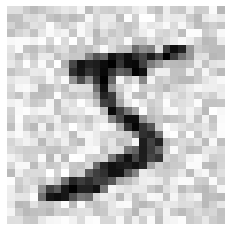

In [82]:
some_index = 0
some_digit_image_mod = X_train_mod[some_index].reshape(28, 28)
plt.imshow(some_digit_image_mod, cmap = mpl.cm.binary, interpolation = 'nearest')
plt.axis('off')
plt.show() #noisy image

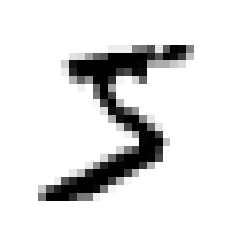

In [78]:
some_digit_test_mod = y_train_mod[some_index].reshape(28, 28)
plt.imshow(some_digit_test_mod, cmap = mpl.cm.binary, interpolation = 'nearest')
plt.axis('off')
plt.show() #target image

In [79]:
knn_clf.fit(X_train_mod, y_train_mod)

In [80]:
clean_digit = knn_clf.predict([X_train_mod[some_index]])

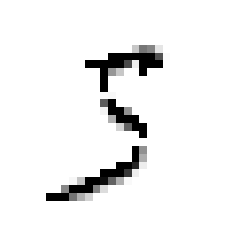

In [81]:
plt.imshow(clean_digit.reshape(28, 28), cmap = mpl.cm.binary, interpolation = 'nearest')
plt.axis('off')
plt.show()

In [83]:
#Look's close enough to the target